Properties of indirect visual input to KCg-ds through LVIN interneurons

In [23]:
import pandas as pd
import numpy as np
from utils import update_ids
from fafbseg import flywire
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from structure import *
from sklearn.preprocessing import binarize
# from utils_flywire import get_inputs
from shuffle import compare_spectrum_shuf, shuf, compare_spectrum_shuf_normalized

In [24]:
font = {'family' : 'Arial',
        'weight': 'normal',
        'size'   : 4}

matplotlib.rc('font', **font)

In [25]:
# Isolate VPNs
metadata = pd.read_csv('../Data/flywire_vpn_metadata_emily_validated_oopdated2.csv') # version with updated type labels
metadata_ind_vpns = metadata[metadata['vPN or LVIN'] == 'vPN'].reset_index()

vpn_ids = list(metadata_ind_vpns['Flywire ID_updated'].astype('string'))
vpn_ids = update_ids(vpn_ids)


In [26]:
# Isolate LVINS
metadata_lvins = metadata[metadata['vPN or LVIN'] == 'LVIN']
#metadata_lvins = metadata_lvins[metadata_lvins['Cell Body Position'] == 'Left']
metadata_lvins = metadata_lvins[metadata_lvins['Synapses to KCg-d_Left'] > 0]
metadata_lvins = metadata_lvins.sort_values(by='Type Code')
lvins = list(metadata_lvins['Flywire ID_updated'])
lvins = update_ids(lvins) 

In [27]:
update_table = pd.DataFrame({'old_id': list(metadata_ind_vpns['Flywire ID_updated']), 'new_id':vpn_ids})

In [28]:
# Threshold by 5 synapses
vpn_lvin_connectivity = flywire.fetch_adjacency(vpn_ids, lvins) 

vpn_lvin_connectivity.sum(axis=1)

metadata_ind_vpns['Synapse sum onto LVINs'] = list(vpn_lvin_connectivity.sum(axis=1))

metadata_ind_vpns = metadata_ind_vpns[metadata_ind_vpns['Synapse sum onto LVINs'] >= 5]

Using live materialization


Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


In [29]:
metadata_ind_vpns = metadata_ind_vpns.sort_values(by='Type Code').reset_index()
vpn_ids = list(metadata_ind_vpns['Flywire ID_updated'])
vpn_ids = update_ids(vpn_ids)

In [30]:
vpn_lvin_connectivity = flywire.fetch_adjacency(vpn_ids, lvins) 

Using materialization version 896


Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


In [31]:
vpn_lvin_connectivity = vpn_lvin_connectivity[vpn_lvin_connectivity > 4].fillna(0)

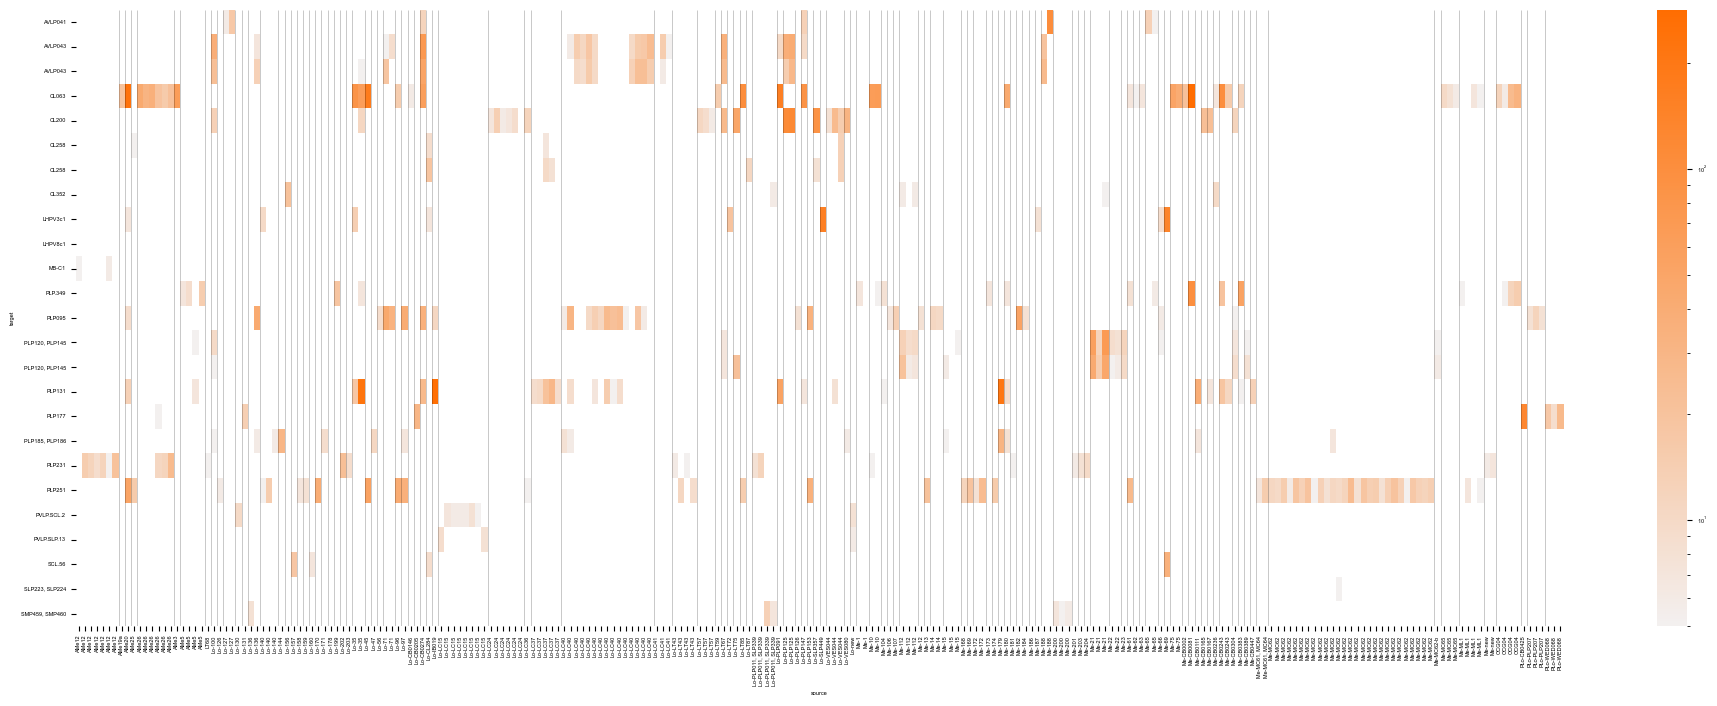

In [49]:
# Colors: Me, Lo, AME, LoP, Oc
# #B50000, #00898B, #F28E02, #34A853, #FF6D01
from matplotlib.colors import LogNorm, Normalize
ax = plt.figure(figsize=(24, 8))
cmap=sns.light_palette("#FF6D01", as_cmap=True)

# create colormap. We take 101 values equally spaced between 0 and 1
# hence the first value 0, second value 0.01
c = np.linspace(0,1,101)
# For those values we store the colors from the "YlOrRd" map in an array
colors = plt.get_cmap(cmap,101)(c)
# We replace the first row of that array, by white
colors[0,:] = np.array([1,1,1,1])
# We create a new colormap with the colors
cmap_2 = matplotlib.colors.ListedColormap(colors)

log_norm = LogNorm(vmin=vpn_lvin_connectivity.min().min(), vmax=vpn_lvin_connectivity.max().max())
ax = sns.heatmap(vpn_lvin_connectivity.T,  xticklabels=list(metadata_ind_vpns['Type Code']), yticklabels=list(metadata_lvins['Type Code']), cmap=cmap, norm=LogNorm())

# type mappings
d = dict([(y,x+1) for x,y in enumerate(sorted(set(list(metadata_ind_vpns['Type Code']))))])
mapped = [d[x] for x in list(metadata_ind_vpns['Type Code'])]
ax.vlines(np.where(np.diff(mapped)>0)[0]+1, *ax.get_ylim(), color='black', alpha=0.3, linewidth=0.5)
plt.savefig('vpn_lvin_connectivity.pdf')

In [13]:
# Save out Source data
vpn_lvin_connectivity.to_csv('../Results/SourceData_Figure3A.csv')
vpn_lvin_connectivity.to_csv('../Data/vpn_lvin_connectivity.csv')

Figure 3 Supplement 2A: inputs to individual LVINs from distinct neuropils

In [11]:
vpn_lvin_connectivity.sum(axis=0)

target
720575940631783372     170.0
720575940632219361     433.0
720575940618422941     332.0
720575940624951847    2111.0
720575940619522974     641.0
720575940622350550      34.0
720575940603976672      69.0
720575940624690116      54.0
720575940615438495     373.0
720575940635718255       0.0
720575940606769854      11.0
720575940622440461     315.0
720575940620343345     592.0
720575940630124050     251.0
720575940631718930     223.0
720575940626248250    1075.0
720575940618445497     229.0
720575940620745069     153.0
720575940611914850     238.0
720575940637736006     870.0
720575940632070370      56.0
720575940619421319      23.0
720575940638124376      69.0
720575940610389602       5.0
720575940616070283      46.0
dtype: float64

In [47]:

lo = []
me = []
ame = []
for lvin in list(vpn_lvin_connectivity.columns):
    incidents = list(vpn_lvin_connectivity.index[np.where(vpn_lvin_connectivity[lvin] > 0)])
    ame_ = 0
    me_ = 0
    lo_ = 0
    for vpn in incidents:
        vpn = update_table[update_table['new_id'] == vpn]['old_id'].item()
        # get input neuropil
        if len(metadata[metadata['Flywire ID_updated'] == vpn]['Source of Visual Input']) > 0:
            neuropil = metadata[metadata['Flywire ID_updated'] == vpn]['Source of Visual Input'].item()
        else:
            neuropil = 'Unknown'
            print(vpn)

        # get weight
        vpn = flywire.update_ids(vpn)['new_id'].item()
        weight = vpn_lvin_connectivity.loc[vpn, lvin]
        
        # add to sums
        if neuropil == 'Lo':
            lo_ += weight
        if neuropil == 'Me':
            me_ += weight
        if neuropil == 'aMe':
            ame_ += weight

    lo.append(lo_)
    me.append(me_)
    ame.append(ame_)
    

In [48]:
df = pd.DataFrame({'lvin': list(vpn_lvin_connectivity.columns), 'lobula_input': lo, 'medulla_input': me, 'ame_input': ame})

In [49]:
new_lvin_ids = update_ids(list(metadata_lvins['Flywire ID_updated']))
lvin_update_table = pd.DataFrame({'old_id': list(metadata_lvins['Flywire ID_updated']), 'new_id':new_lvin_ids})

In [50]:
lvin_names = []
for lvin in list(df['lvin']):
    lvin = lvin_update_table[lvin_update_table['new_id'] == lvin]['old_id'].item()
    lvin_name = metadata_lvins[metadata_lvins['Flywire ID_updated'] == lvin]['Type'].item()
    lvin_names.append(lvin_name)

In [51]:
df['lvin_names'] = lvin_names

In [52]:
# Save out Source Data
df.to_csv('../Results/SourceData_Figure3Supp2A.csv')

In [53]:
df = df.drop(columns=['lvin'])

<Figure size 10000x500 with 0 Axes>

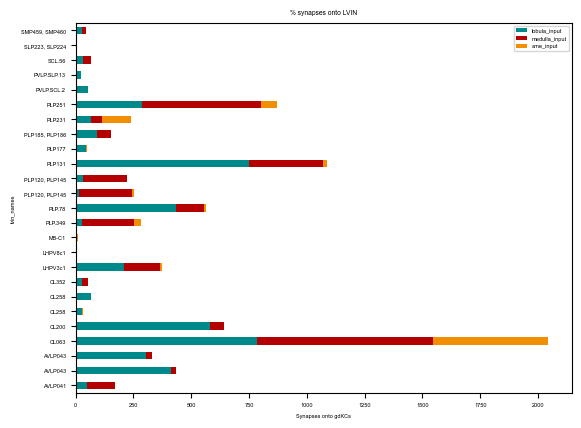

In [54]:
# plot a Stacked Bar Chart using matplotlib
# Colors: Me, Lo, AME
# #B50000, #00898B, #F28E02
me_color = '#B50000'
lo_color = '#00898B'
ame_color = '#F28E02'

plt.figure(figsize=(100, 5))
df.plot(
  x = 'lvin_names', 
  kind = 'barh', 
  stacked = True, 
  title = '% synapses onto LVIN', 
  mark_right = True, color=[lo_color, me_color, ame_color])
  
#df_total = df["lobula_input"] + df["medulla_input"] + df["ame_input"]
#df_rel = df[df.columns[1:-1]].div(df_total, 0)*100
plt.xlabel('Synapses onto gdKCs')
  
# for n in df_rel:
#     for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
#                                          df[n], df_rel[n])):
#         plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
#                  va = 'center', ha = 'center')
plt.savefig('inputs_to_lvins.pdf')

Figure 3E: Structure in VPN-LVIN connectivity

In [12]:
# Find indirect VPNs
metadata = pd.read_csv('../Data/flywire_vpn_metadata_emily_validated - vPN_KCgd_metadata.csv')
metadata_ind_vpns = metadata[metadata['vPN or LVIN'] == 'vPN'].reset_index()

In [13]:
# Isolate indirect inputs through lvins
metadata_lvins = metadata[metadata['vPN or LVIN'] == 'LVIN']
metadata_lvins = metadata_lvins[metadata_lvins['Cell Body Position'] == 'Left']
metadata_lvins = metadata_lvins.sort_values(by='Type Code')
lvins = list(metadata_lvins['Flywire ID'])
lvins = update_ids(lvins) 

vpn_ids = list(metadata_ind_vpns['Flywire ID'])
vpn_ids = update_ids(vpn_ids)

In [14]:
# Threshold by 5 synapses
vpn_lvin_connectivity = flywire.fetch_adjacency(vpn_ids, lvins) 

vpn_lvin_connectivity.sum(axis=1)

metadata_ind_vpns['Synapse sum onto LVINs'] = list(vpn_lvin_connectivity.sum(axis=1))

metadata_ind_vpns = metadata_ind_vpns[metadata_ind_vpns['Synapse sum onto LVINs'] >= 5]

Using live materialization


Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


In [15]:
metadata_ind_vpns = metadata_ind_vpns.sort_values(by='Type Code').reset_index()
vpn_ids = list(metadata_ind_vpns['Flywire ID'])
vpn_ids = update_ids(vpn_ids)

In [16]:
vpn_lvin_connectivity = flywire.fetch_adjacency(vpn_ids, lvins) 

Using materialization version 896


Using deprecated pyarrow serialization method, please upgrade CAVEClient>=5.9.0 with pip install --upgrade caveclient


In [17]:
vpn_lvin_connectivity = binarize(np.array(vpn_lvin_connectivity).T) 

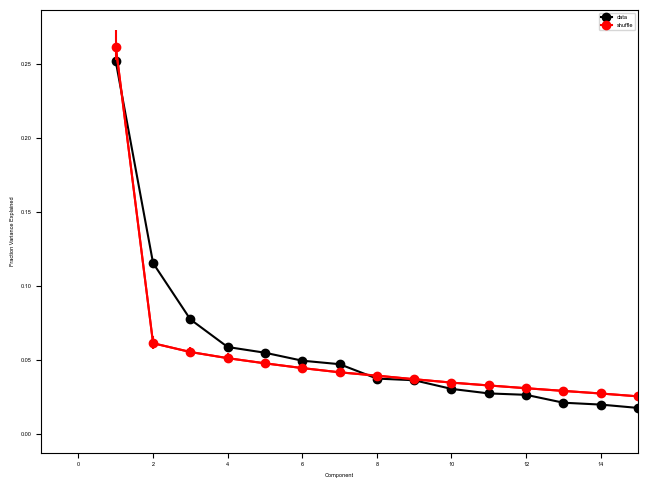

In [20]:
vpn_lvin = compare_spectrum_shuf(vpn_lvin_connectivity, shuf, 'vpn_lvin_pca')

In [22]:
results = pd.DataFrame({'Data': vpn_lvin[0], 'Shuffle mean': vpn_lvin[1], 'Shuffle min': vpn_lvin[2], 'Shuffle max': vpn_lvin[3]})
results.to_csv('../Results/SourceData_Figure3E.csv')